**Промышленность. Предсказание температуры.**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

**Цель:** Предсказание температуры сплава



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import (OneHotEncoder, 
                                     OrdinalEncoder, 
                                     StandardScaler, 
                                     MinMaxScaler, 
                                     RobustScaler,
                                     PolynomialFeatures)
from sklearn.linear_model import LinearRegression, Lasso, Ridge,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
#import my_function as fc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest,f_classif, mutual_info_classif  

import warnings
from sklearn.dummy import DummyRegressor, DummyClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV 
import shap

plt.rcParams["figure.figsize"] = (14,7)

warnings.filterwarnings('ignore')
RANDOM_STATE =  220424

In [2]:
# Функции
def data_info(data_list:dict):
        for k, v in data_list.items():
            print('Name dataframe:', k.upper(),'\n')
            display(v.head())
            display(v.describe())
            print(v.info(),'\n')
            print('-'*50)

def analysis(df, step:int):
    if step==1:
        for i in df.select_dtypes(include='object').columns:
            print('-----',i,'-----')
            print(df[i].value_counts())
            print()
            pie(df[i].value_counts(), i);
    if step==2:
        for i in df.select_dtypes(exclude='object').columns:
            print('------',i,'---------')
            print(df[i].describe())
            print()
            boxhist(data=df, x=i, title=i);         
def boxhist(data, x, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.boxplot(ax=axes[0],data=data, x=x,palette="crest");
    axes[0].set_xlabel(title)
    axes[0].set_title(title)
    sns.histplot(ax=axes[1],data=data, x=x, kde=True, palette="crest");
    axes[1].set_title(title);
    axes[1].set_xlabel(title)
    axes[1].axvline(data[x].mean(), c='k', ls='-', lw=2.5)
    axes[1].axvline(data[x].median(), c='orange', ls='--', lw=2.5)
    plt.xlabel(title);
    plt.show()
    
# ящик с усами
def boxplot(data,  title):
    sns.boxplot(data=data, palette="crest");
    plt.title(title)
    plt.show()
    
    
def OSCV(estimator, parametrs, n_trials):
    return OptunaSearchCV(
    estimator,
    parametrs,
    cv=5,
    scoring='neg_mean_absolute_error' ,
    #error_score='raise',
    n_jobs=-1,
    n_trials=n_trials,
    random_state=RANDOM_STATE
) 
def RSCV(estimator, parametrs):
    return RandomizedSearchCV(
    estimator,
    parametrs,
    cv=5,
    scoring='neg_mean_absolute_error' ,
    error_score='raise',
    n_jobs=-1
    #n_trials=n_trials,
    #random_state=RANDOM_STATE
) 

def emissions(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = 1.5 * (q3 -q1)
    df.loc[df[column]>q3+iqr, column]=q3+iqr
    df.loc[df[column]<q1-iqr, column]=q1-iqr
    return df
def emissions_del(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = 1.5 * (q3 -q1)
    df = df[df[column]<=q3+iqr]
    df = df[df[column]>=q1-iqr]
    return df

## Загрузка данных

In [3]:
try:
    data_arc = pd.read_csv('C:/Users/Serg/practicum/database/final_project/data_arc_new.csv')
    data_bulk = pd.read_csv('C:/Users/Serg/practicum/database/final_project/data_bulk_new.csv')
    data_bult_time = pd.read_csv('C:/Users/Serg/practicum/database/final_project/data_bulk_time_new.csv')
    data_gas = pd.read_csv('C:/Users/Serg/practicum/database/final_project/data_gas_new.csv')
    data_temp = pd.read_csv('C:/Users/Serg/practicum/database/final_project/data_temp_new.csv')
    data_wire = pd.read_csv('C:/Users/Serg/practicum/database/final_project/data_wire_new.csv')
    data_wire_time = pd.read_csv('C:/Users/Serg/practicum/database/final_project/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bult_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
    
    
data_list ={
        'arc':data_arc, 'bulk': data_bulk, 'bulk_time':data_bult_time,'gas':data_gas,
        'temp': data_temp, 'wire':data_wire, 'wire_time':data_wire_time
}

In [4]:
data_info(data_list)

Name dataframe: ARC 



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None 

--------------------------------------------------
Name dataframe: BULK 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB
None 

--------------------------------------------------
Name dataframe: BULK_TIME 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB
None 

--------------------------------------------------
Name dataframe: GAS 



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None 

--------------------------------------------------
Name dataframe: TEMP 



,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None 

--------------------------------------------------
Name dataframe: WIRE 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None 

--------------------------------------------------
Name dataframe: WIRE_TIME 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None 

--------------------------------------------------


**Вывод**

Данные загружены. В таблицах присутствуют пропуски. Так же следует привести некоторые признаки к нужному типу данных и привести названия столбцов к стандарту. В data_arc в столбце реактивной мощности присутствует отрицательное значение.


## Предобработка данных

### Изменим названия столбцов

In [5]:
# Изменим названия столбцов
data_arc.columns=['key', 'start_arc', 'final_arc','active_power','reactive_power']
data_arc['start_arc'] = pd.to_datetime(data_arc['start_arc'])
data_arc['final_arc'] = pd.to_datetime(data_arc['final_arc'])

In [6]:
bulk_list=['key','bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
          'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']
data_bulk.columns = bulk_list
data_bult_time.columns = bulk_list
for i in range(1, len(bulk_list)):
    name =bulk_list[i]
    data_bult_time[name] = pd.to_datetime(data_bult_time[name])

In [7]:
data_gas.columns = ['key','gas']


In [8]:
data_temp.columns = ['key', 'time','temperature']
data_temp['time'] = pd.to_datetime(data_temp['time'])


In [9]:
wire_list = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
data_wire.columns = wire_list
data_wire_time.columns = wire_list

for i in range(1, len(wire_list)):
    name =wire_list[i]
    data_wire_time[name] = pd.to_datetime(data_wire_time[name])

In [10]:
data_list ={
        'arc':data_arc, 'bulk': data_bulk, 'bulk_time':data_bult_time,'gas':data_gas,
        'temp': data_temp, 'wire':data_wire, 'wire_time':data_wire_time
}
data_info(data_list)

Name dataframe: ARC 



,key,start_arc,final_arc,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,start_arc,final_arc,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_arc       14876 non-null  datetime64[ns]
 2   final_arc       14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None 

--------------------------------------------------
Name dataframe: BULK 



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB
None 

--------------------------------------------------
Name dataframe: BULK_TIME 



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB
None 

----------------

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None 

--------------------------------------------------
Name dataframe: TEMP 



,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,time,temperature
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18092 non-null  int64         
 1   time         18092 non-null  datetime64[ns]
 2   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
None 

--------------------------------------------------
Name dataframe: WIRE 



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None 

--------------------------------------------------
Name dataframe: WIRE_TIME 



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
None 

--------------------------------------------------


### Данные об электродах


In [11]:
display(data_arc.duplicated().sum())
data_arc.isna().sum()


0

key               0
start_arc         0
final_arc         0
active_power      0
reactive_power    0
dtype: int64

Пропусков нет. Дубликатов нет.

In [12]:
# разберемся с отрицательными значениями
data_arc.loc[data_arc['reactive_power']<=0]

,key,start_arc,final_arc,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [13]:
#удалим ключ
data_arc = data_arc.query('key!=2116')

In [14]:
data_arc.loc[data_arc['key']==2116]

,key,start_arc,final_arc,active_power,reactive_power


In [15]:
#сколько времени занимает процесс.
(data_arc['final_arc'] - data_arc['start_arc']).describe()

count                        14872
mean     0 days 00:02:51.688004303
std      0 days 00:01:38.193604089
min                0 days 00:00:11
25%                0 days 00:01:47
50%                0 days 00:02:27
75%                0 days 00:03:34
max                0 days 00:15:07
dtype: object

Средняя продолжительность процесса 3 минуты. Максимальная 15 минут, минимальная 11 секунд.

------ active_power ---------
count    14872.000000
mean         0.662753
std          0.258916
min          0.223120
25%          0.467114
50%          0.599587
75%          0.830314
max          1.463773
Name: active_power, dtype: float64



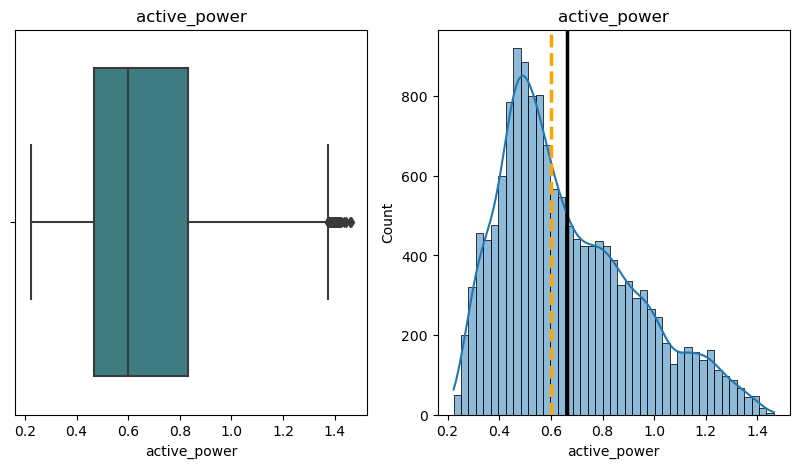

------ reactive_power ---------
count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64



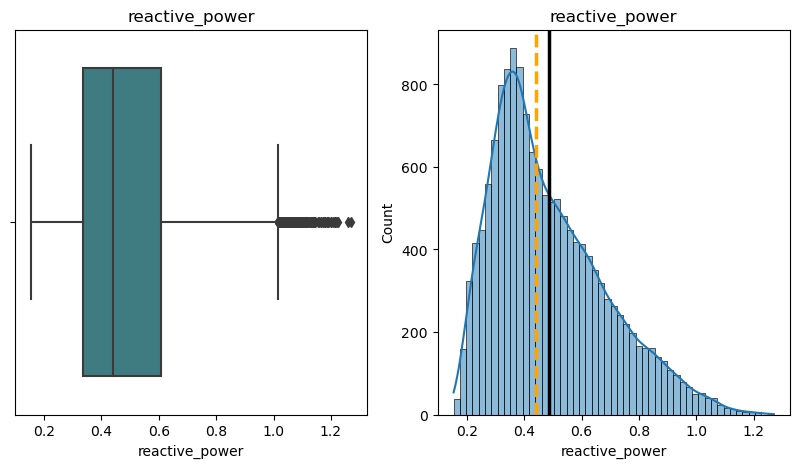

In [16]:
analysis(data_arc[['active_power','reactive_power']], step=2)

В данных присутствуют выбросы. Признаки нормально распределены с уклоном в право.

Добавим в data_arc новые признаки: 
- полной мощности.
- работу
- длительность обработки электродами в секундах.
Полная мощность вычисляется по формуле: 
 
 S = √P²+Q²
 
 Формула Работы:
 
 A = S*t;  


In [17]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
data_arc['duration_arc'] = (data_arc['final_arc'] - data_arc['start_arc']).dt.total_seconds()
data_arc['A'] = data_arc['full_power'] * data_arc['duration_arc']
data_arc.head()

,key,start_arc,final_arc,active_power,reactive_power,full_power,duration_arc,A
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0,159.830252


In [18]:
columns_arc = {
    'key'            : 'count', 
    'start_arc'      : 'first',
    'final_arc'      : 'last',
    'active_power'   : 'mean',
    'reactive_power' : 'mean',
    'full_power'     : 'mean',
    'duration_arc'   : 'sum',
    'A'              : 'sum'
}

In [19]:
arc_pivot = data_arc.pivot_table(index='key',aggfunc=columns_arc).rename(columns={'key':'count_arc'})

удалим столбцы с активной и реактивной мощностью и датой

In [20]:
arc_pivot = arc_pivot.drop(['active_power','reactive_power','start_arc','final_arc'], axis=1)

In [21]:
arc_pivot

,A,duration_arc,full_power,count_arc
key,,,,
1,770.282114,1098.0,0.743747,5
2,481.760005,811.0,0.647087,4
3,722.837668,655.0,1.003845,5
4,683.455597,741.0,0.850010,4
5,512.169934,869.0,0.704245,4
...,...,...,...,...
3237,630.503534,909.0,0.650131,5
3238,286.052252,546.0,0.574646,3
3239,941.538764,1216.0,0.751810,8


### Данные о подаче сыпучих материалов (объём)

In [22]:
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [23]:
#len(data_bulk.loc[data_bulk['key']<2500])

In [24]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


`bulk 8` использовался всего один раз. Больше всего использовался `bulk 14`/

Минимальный объём использованной продукции у `bulk 3` - 6 кубов.
Максимальный у `bulk 12` -1849 кубов. Что больше похоже на аномалию из-за слишком высокого значения.


In [25]:
data_bulk = data_bulk.drop(['bulk_8'],axis=1)

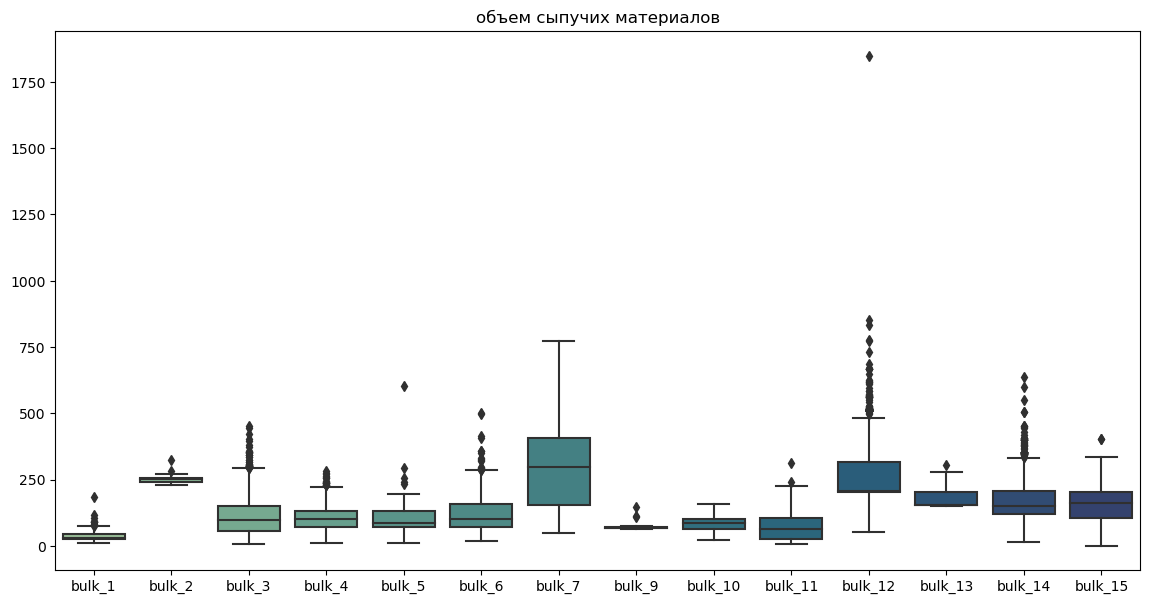

In [26]:
boxplot(data_bulk.drop(['key'],axis=1),'объем сыпучих материалов')

Видим аномалию у bulk 12. удалим её. Остальные выбросы оставим.

In [27]:
#data_bulk=data_bulk.query('bulk_12 < 1750')
data_bulk = data_bulk.set_index(['key'])
#data_bulk['bulk_mean'] = data_bulk.mean(axis=1)

Все пропуски заменим на нули.

In [28]:
data_bulk = data_bulk.fillna(0)
data_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### Данные о подаче сыпучих материалов (время)

In [29]:
data_bult_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [30]:
# поиск дубликатов
data_bult_time.duplicated().sum()

0

Явных ошибок или аномалий в данных не видно.

### данные о продувке сплава газом

In [31]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


------ gas ---------
count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64



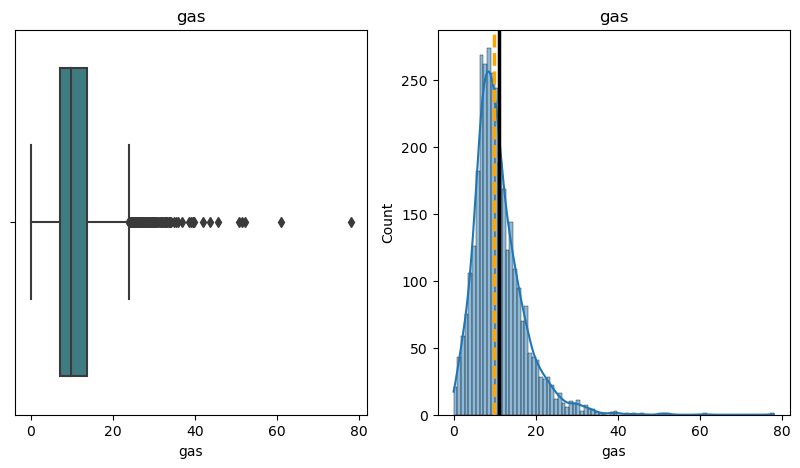

In [32]:
analysis(data_gas.drop(['key'],axis=1),step=2)

Минимальный объем газа 0,008 кубов.
Максимальный 78 кубов.

Присутствуют выбросы. Посмотрим сколько данных больше 40.

In [33]:
data_gas.loc[data_gas['gas']>=40]

,key,gas
116,117,50.581035
277,280,60.935689
319,322,77.995040
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
2107,2110,52.142373
2567,2570,51.380229


удалим значения объема газа больше 40

In [34]:
data_gas = data_gas.query('gas<40')
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [35]:
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [36]:
data_gas = data_gas.set_index('key')


### данные измерения температуры

In [37]:
data_temp

,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [38]:
data_temp.isna().sum()


key               0
time              0
temperature    3427
dtype: int64

In [39]:
data_temp.duplicated().sum()

0

In [40]:
# найдем ключи у которых замеры проводились один раз
#data_temp = data_temp.dropna()
t= data_temp.pivot_table(index ='key',values ='temperature', aggfunc='count')
del_key = t.loc[t['temperature']==1].index


In [41]:
len(del_key)

741

In [42]:
data_temp = data_temp[~data_temp['key'].isin(del_key)]

In [43]:
data_temp

,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


Удалили все ключи где замер температуры был меньше 2 раз. Теперь удалим ключи где температура менее 1500  

In [44]:
del_key =data_temp.loc[data_temp['temperature']<1500,'key']

In [45]:
del_key.values

array([ 867, 1214, 1619, 2052], dtype=int64)

In [46]:
data_temp = data_temp[~data_temp['key'].isin(del_key)]

In [47]:
data_temp = data_temp.dropna()

In [48]:
data_temp

,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [49]:
columns_temp = { 
    'time'         : ['first','last'],
    'temperature'  : ['first','last']
    
}

In [50]:
temp_pivot = data_temp.pivot_table(index='key',aggfunc=columns_temp)
temp_pivot.columns=['temp_begin', 'temp_final','time_first','time_final']

In [51]:
temp_pivot

,temp_begin,temp_final,time_first,time_final
key,,,,
1,1571.0,1613.0,2019-05-03 11:02:04,2019-05-03 11:30:38
2,1581.0,1602.0,2019-05-03 11:34:04,2019-05-03 11:55:09
3,1596.0,1599.0,2019-05-03 12:06:44,2019-05-03 12:35:57
4,1601.0,1625.0,2019-05-03 12:39:27,2019-05-03 12:59:47
5,1576.0,1602.0,2019-05-03 13:11:03,2019-05-03 13:36:39
...,...,...,...,...
2495,1570.0,1591.0,2019-08-10 11:27:47,2019-08-10 11:50:47
2496,1554.0,1591.0,2019-08-10 11:56:48,2019-08-10 12:25:13
2497,1571.0,1589.0,2019-08-10 12:37:26,2019-08-10 12:53:28


In [52]:
temp_pivot.isna().sum()

temp_begin    0
temp_final    0
time_first    0
time_final    0
dtype: int64

Распределение нормальное. Присутствуют выбросы.

Создадим новый признак, показывающий кол-во секунд, прошедших от первого замера температуры до последнего и удалим столбцы с датой.

In [53]:
temp_pivot['temp_duration'] = (temp_pivot['time_final'] - temp_pivot['time_first']).dt.total_seconds()
temp_pivot = temp_pivot.drop(['time_final', 'time_first'],axis=1)

------ temp_begin ---------
count    2471.000000
mean     1589.012950
std        25.004369
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: temp_begin, dtype: float64



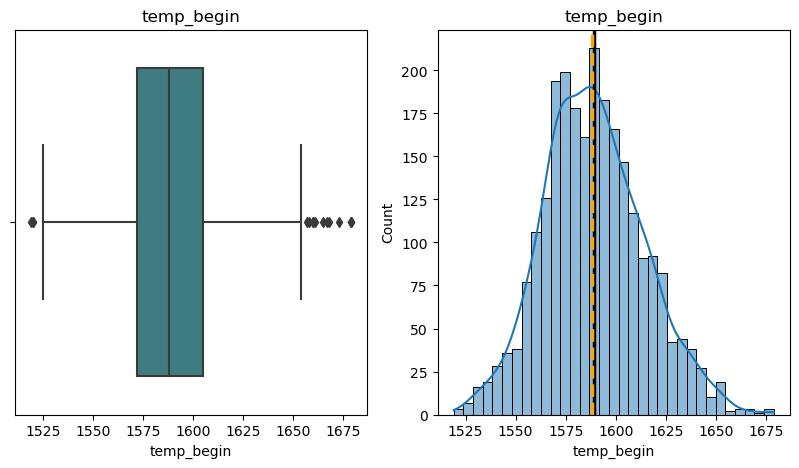

------ temp_final ---------
count    2471.000000
mean     1595.339943
std        16.035215
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: temp_final, dtype: float64



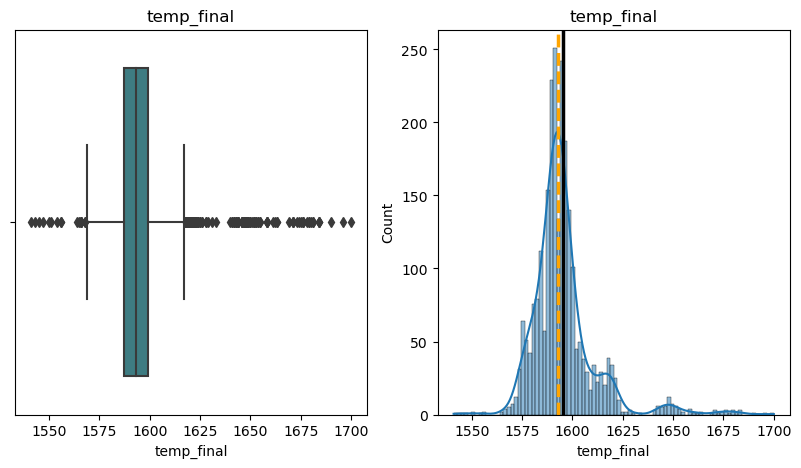

------ temp_duration ---------
count     2471.000000
mean      2281.317685
std       1374.343709
min        339.000000
25%       1544.500000
50%       2007.000000
75%       2739.500000
max      23674.000000
Name: temp_duration, dtype: float64



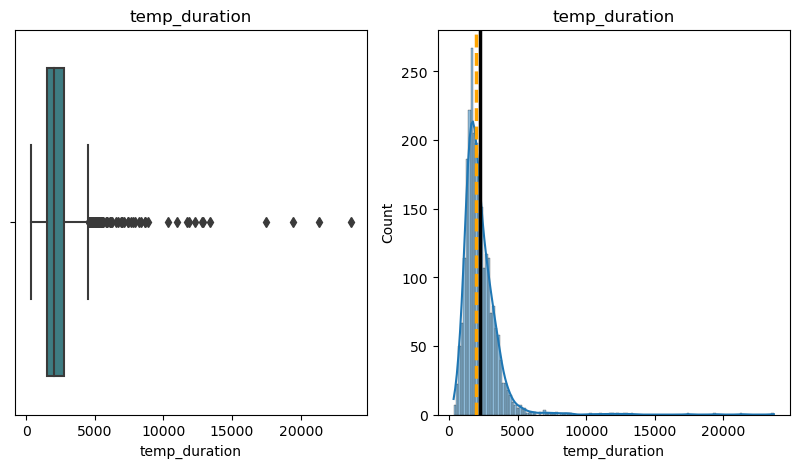

In [54]:
analysis(temp_pivot,step=2)

In [55]:
temp_pivot

,temp_begin,temp_final,temp_duration
key,,,
1,1571.0,1613.0,1714.0
2,1581.0,1602.0,1265.0
3,1596.0,1599.0,1753.0
4,1601.0,1625.0,1220.0
5,1576.0,1602.0,1536.0
...,...,...,...
2495,1570.0,1591.0,1380.0
2496,1554.0,1591.0,1705.0
2497,1571.0,1589.0,962.0


### Данные о проволочных материалах (объём);

In [56]:
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
data_wire.duplicated().sum()

0

In [58]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [59]:
data_wire = data_wire.set_index(['key'])
data_wire = data_wire.drop(['wire_5'],axis=1)
#data_wire['wire_mean'] = data_wire.mean(axis=1)

data_wire

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN


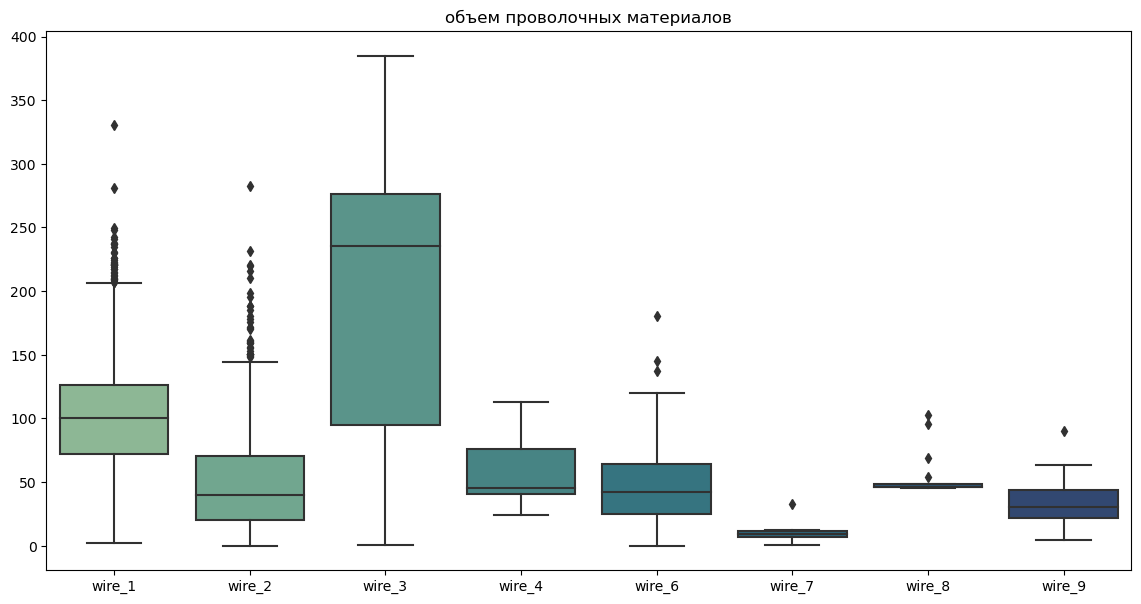

In [60]:
boxplot(data_wire,'объем проволочных материалов')

Материал №5 испоьзовался только 1 раз, чаще всего использовался материал №1 - более 3 тысяч раз.

Выбросы присутствуют везде кроме wire 3-5.Явных аномалий нет.

In [61]:
#заменим пропуски нулями
data_wire = data_wire.fillna(0)

### данные о проволочных материалах (время)

In [62]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [63]:
data_wire_time.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
data_wire_time.duplicated().sum()

0

Много пропусков, дубликатов нет, аномалии отстуствуют 

**Вывод**
Проведены исследования и преобразования следующих таблиц:
1. данные об электродах(date_arc):
  - удалены все итерации ключа у которого присутствовала отрицательная реактивная мощность.
  - проверены на пропуски и дубликаты.
  - Были агрегированы данные по ключу.
  
    Добавлены новые признаки:
   - Полной мощности.
   - Работы.
   - Количества итераций.
   - Время работы электродов в секундах.   
     Удалены столбцы:
   - Дата\времени
   - активной мощности
   - реактивной мощности.
2. Данные о подаче сыпучих материалов (объём и времени)(data_bulk, data_bult_time):
- удален bulk 8 т.к. был применен 1 раз.
- удалены аномалии.
- все пропуски заменены на 0.
- удалены признаки с датой/временем.
3. Данные о газе(data_gas):
- Удалены аномалии.
4 Данные о температуре(data_temp):
- Были агрегированы данные по ключу/
- Удалены ключи где замер температуры производился только один раз.
- созданы признаки Начальной и последней температуры. и прошедшим временем между последним замером и первым.
- удалены признаки с датой/временем.
5. Данные о данные о проволочных материалах(data_wire, data_wire_time):
- удален wire 5 т.к. был применен 1 раз.
- удалены аномалии.
- все пропуски заменены на 0.
-  удалены признаки с датой/временем.


## Объединение данных 

In [65]:
datalist = [temp_pivot, data_bulk,data_gas,data_wire]
data_final = arc_pivot

In [66]:
for i in datalist:
    data_final = data_final.merge(i, on='key',how='inner')

In [67]:
data_final.shape

(2317, 30)

In [68]:
data_final.tail()

,A,duration_arc,full_power,count_arc,temp_begin,temp_final,temp_duration,bulk_1,bulk_2,bulk_3,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
2495,694.177326,723.0,0.967180,4,1570.0,1591.0,1380.0,0.0,0.0,21.0,...,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2496,815.818538,940.0,0.845053,6,1554.0,1591.0,1705.0,0.0,0.0,0.0,...,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2497,823.020520,569.0,1.453639,3,1571.0,1589.0,962.0,0.0,0.0,0.0,...,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2498,581.810739,750.0,0.781983,5,1591.0,1594.0,1520.0,0.0,0.0,90.0,...,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2499,532.386183,883.0,0.542313,4,1569.0,1603.0,1537.0,0.0,0.0,47.0,...,227.0,11.336151,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2317 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   A              2317 non-null   float64
 1   duration_arc   2317 non-null   float64
 2   full_power     2317 non-null   float64
 3   count_arc      2317 non-null   int64  
 4   temp_begin     2317 non-null   float64
 5   temp_final     2317 non-null   float64
 6   temp_duration  2317 non-null   float64
 7   bulk_1         2317 non-null   float64
 8   bulk_2         2317 non-null   float64
 9   bulk_3         2317 non-null   float64
 10  bulk_4         2317 non-null   float64
 11  bulk_5         2317 non-null   float64
 12  bulk_6         2317 non-null   float64
 13  bulk_7         2317 non-null   float64
 14  bulk_9         2317 non-null   float64
 15  bulk_10        2317 non-null   float64
 16  bulk_11        2317 non-null   float64
 17  bulk_12        2317 non-null   float64
 18  bulk_13      

Создадим признак
с датой не понадобятся.Удалим их.

In [70]:
data_final.isna().sum()

A                0
duration_arc     0
full_power       0
count_arc        0
temp_begin       0
temp_final       0
temp_duration    0
bulk_1           0
bulk_2           0
bulk_3           0
bulk_4           0
bulk_5           0
bulk_6           0
bulk_7           0
bulk_9           0
bulk_10          0
bulk_11          0
bulk_12          0
bulk_13          0
bulk_14          0
bulk_15          0
gas              0
wire_1           0
wire_2           0
wire_3           0
wire_4           0
wire_6           0
wire_7           0
wire_8           0
wire_9           0
dtype: int64

In [71]:
data_final.head()

,A,duration_arc,full_power,count_arc,temp_begin,temp_final,temp_duration,bulk_1,bulk_2,bulk_3,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,770.282114,1098.0,0.743747,5,1571.0,1613.0,1714.0,0.0,0.0,0.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,481.760005,811.0,0.647087,4,1581.0,1602.0,1265.0,0.0,0.0,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,722.837668,655.0,1.003845,5,1596.0,1599.0,1753.0,0.0,0.0,0.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,683.455597,741.0,0.850010,4,1601.0,1625.0,1220.0,0.0,0.0,0.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,512.169934,869.0,0.704245,4,1576.0,1602.0,1536.0,0.0,0.0,0.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
#  удалим признаки где пропусков более 80%
for i in data_final.columns:
    if ((data_final[i]==0).sum() / data_final[i].count()) >= 0.8:
         data_final = data_final.drop([i],axis=1)
data_final.head()

,A,duration_arc,full_power,count_arc,temp_begin,temp_final,temp_duration,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,wire_1,wire_2
key,,,,,,,,,,,,,,,
1,770.282114,1098.0,0.743747,5,1571.0,1613.0,1714.0,0.0,43.0,206.0,150.0,154.0,29.749986,60.059998,0.00000
2,481.760005,811.0,0.647087,4,1581.0,1602.0,1265.0,0.0,73.0,206.0,149.0,154.0,12.555561,96.052315,0.00000
3,722.837668,655.0,1.003845,5,1596.0,1599.0,1753.0,0.0,34.0,205.0,152.0,153.0,28.554793,91.160157,0.00000
4,683.455597,741.0,0.850010,4,1601.0,1625.0,1220.0,0.0,81.0,207.0,153.0,154.0,18.841219,89.063515,0.00000
5,512.169934,869.0,0.704245,4,1576.0,1602.0,1536.0,0.0,78.0,203.0,151.0,152.0,5.413692,89.238236,9.11456


### Исследовательский анализ объединенной таблицы

------ A ---------
count    2317.000000
mean      668.907094
std       316.974199
min        33.430208
25%       457.872635
50%       630.913482
75%       840.707237
max      4546.405812
Name: A, dtype: float64



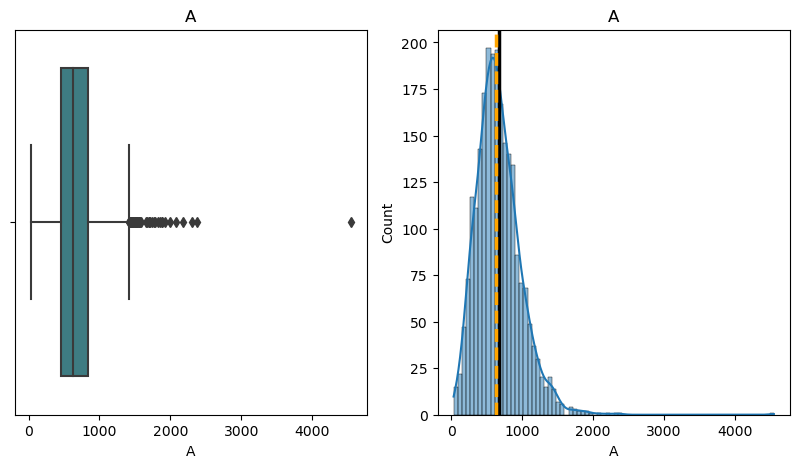

------ duration_arc ---------
count    2317.000000
mean      805.716012
std       335.526776
min        57.000000
25%       581.000000
50%       778.000000
75%       992.000000
max      4189.000000
Name: duration_arc, dtype: float64



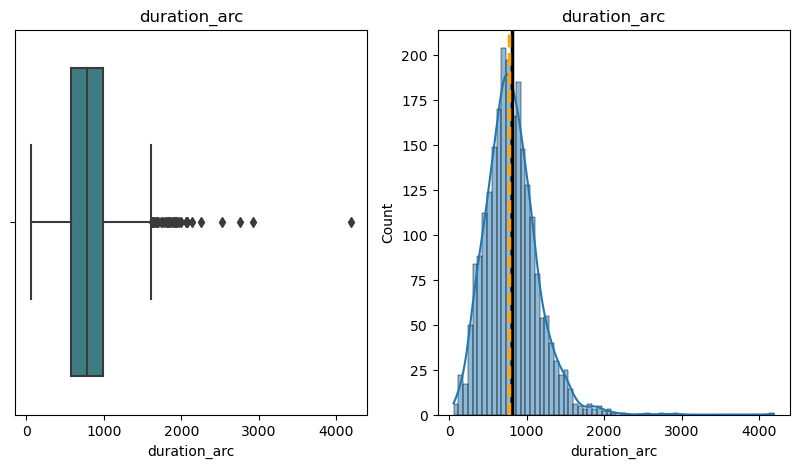

------ full_power ---------
count    2317.000000
mean        0.826086
std         0.160234
min         0.331897
25%         0.714413
50%         0.818378
75%         0.921634
max         1.572238
Name: full_power, dtype: float64



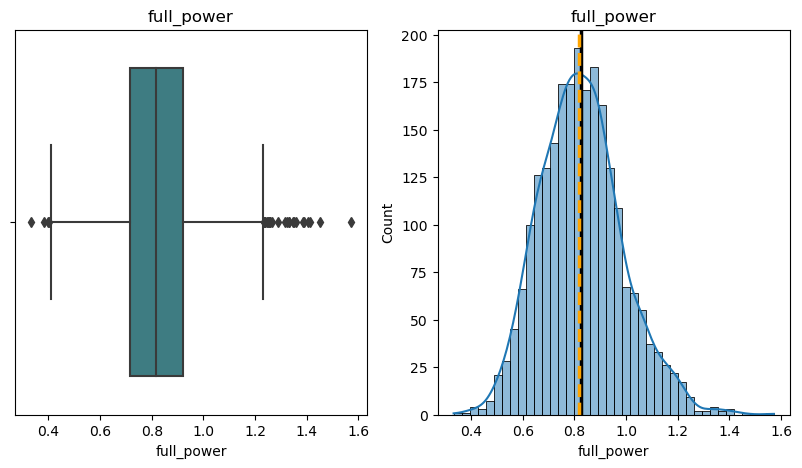

------ count_arc ---------
count    2317.000000
mean        4.684506
std         1.577636
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        15.000000
Name: count_arc, dtype: float64



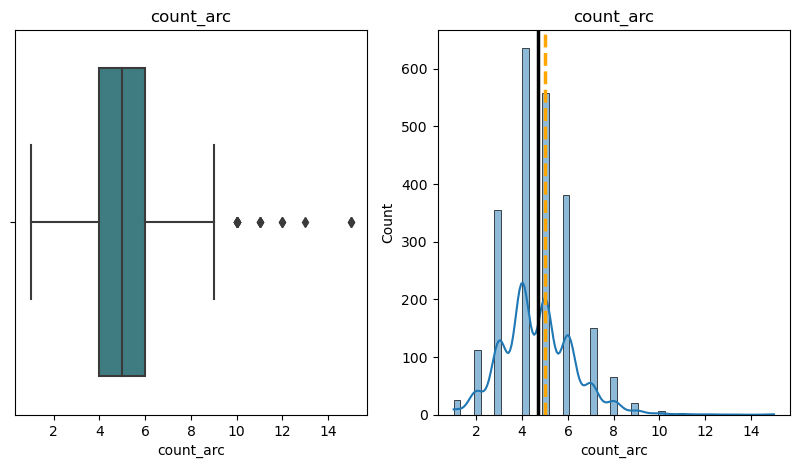

------ temp_begin ---------
count    2317.000000
mean     1587.321968
std        23.554257
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: temp_begin, dtype: float64



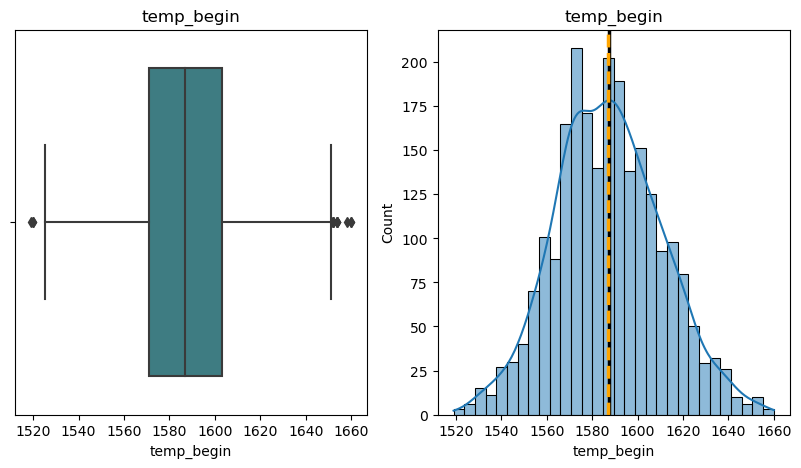

------ temp_final ---------
count    2317.000000
mean     1593.388433
std        11.108633
min      1543.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temp_final, dtype: float64



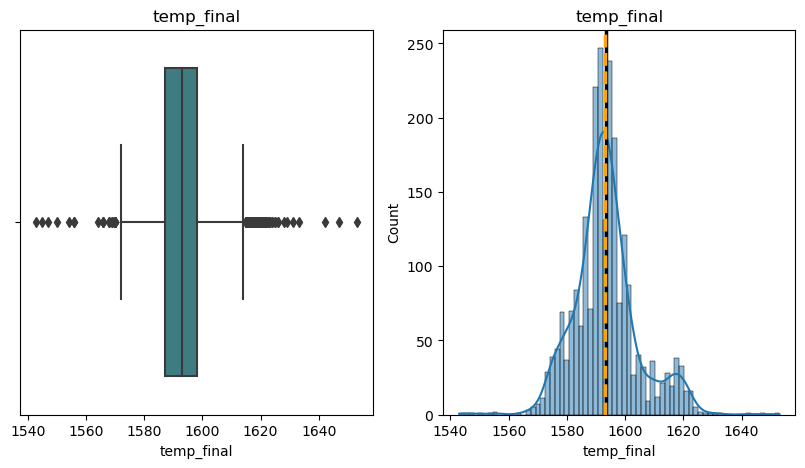

------ temp_duration ---------
count     2317.000000
mean      2309.283125
std       1321.665231
min        339.000000
25%       1579.000000
50%       2045.000000
75%       2781.000000
max      23674.000000
Name: temp_duration, dtype: float64



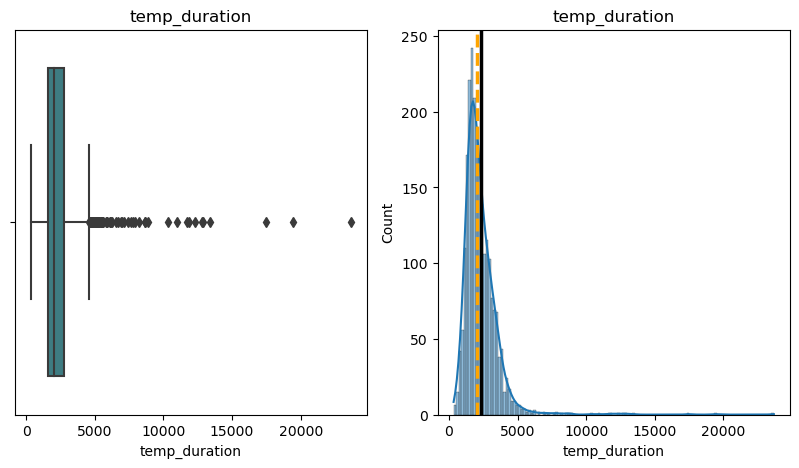

------ bulk_3 ---------
count    2317.000000
mean       47.318947
std        75.292037
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64



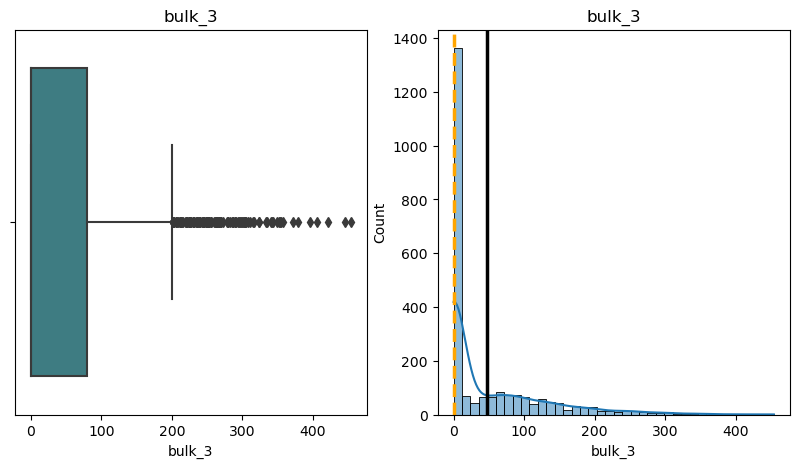

------ bulk_4 ---------
count    2317.000000
mean       37.223133
std        58.684520
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: bulk_4, dtype: float64



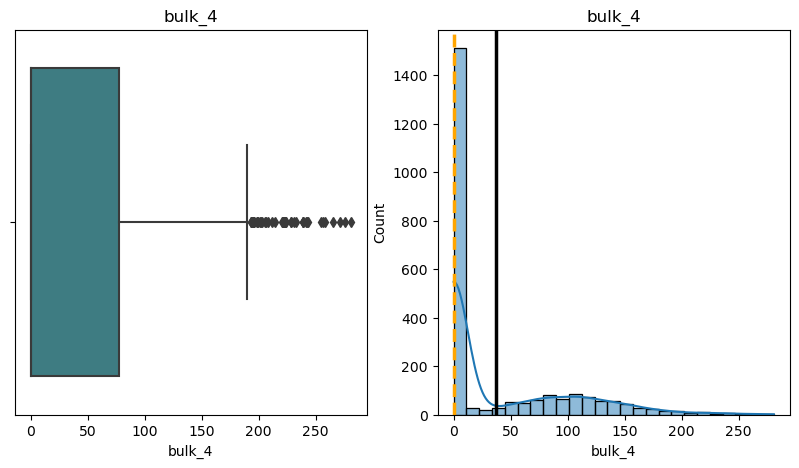

------ bulk_12 ---------
count    2317.000000
mean      207.870954
std       152.903921
min         0.000000
25%       105.000000
50%       206.000000
75%       282.000000
max       853.000000
Name: bulk_12, dtype: float64



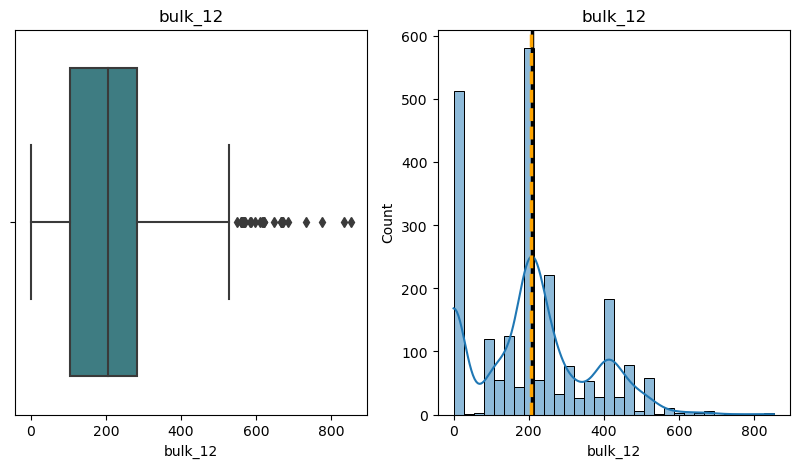

------ bulk_14 ---------
count    2317.000000
mean      153.768666
std        80.575681
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       450.000000
Name: bulk_14, dtype: float64



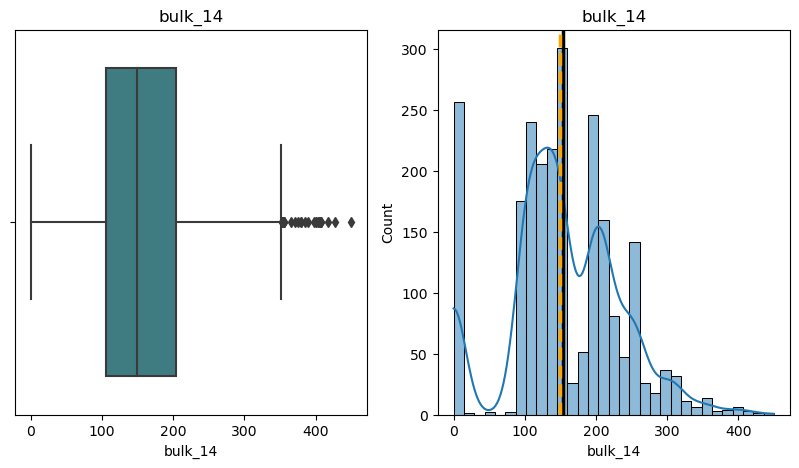

------ bulk_15 ---------
count    2317.000000
mean      120.309883
std        84.580708
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64



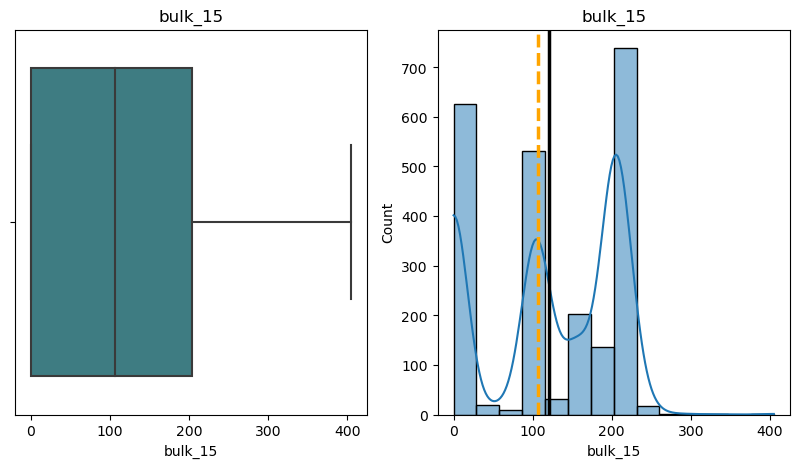

------ gas ---------
count    2317.000000
mean       11.252333
std         5.942574
min         0.008399
25%         7.268466
50%        10.087175
75%        14.172557
max        39.728826
Name: gas, dtype: float64



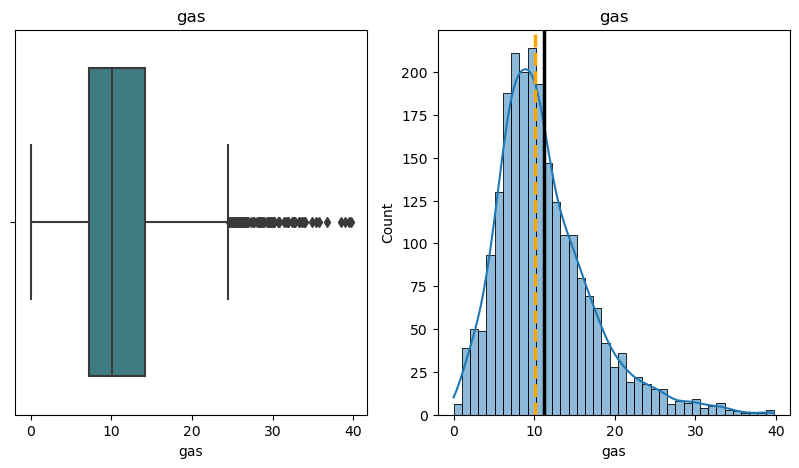

------ wire_1 ---------
count    2317.000000
mean      102.480615
std        43.232836
min         0.000000
25%        73.295036
50%       101.119201
75%       127.763997
max       330.314424
Name: wire_1, dtype: float64



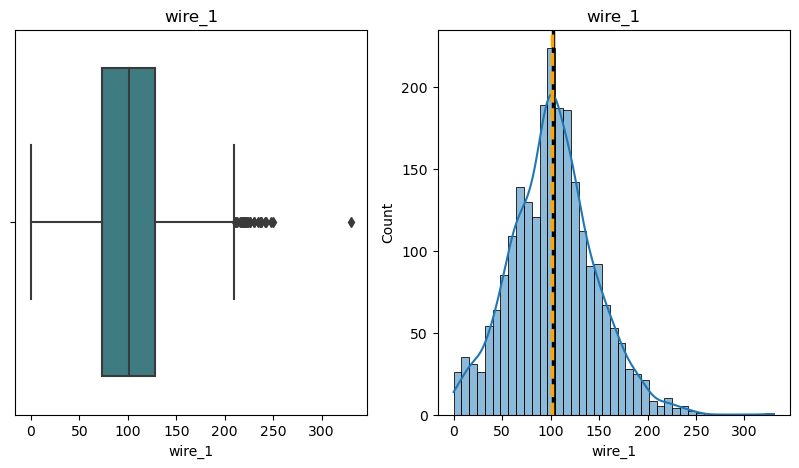

------ wire_2 ---------
count    2317.000000
mean       17.552284
std        33.479778
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: wire_2, dtype: float64



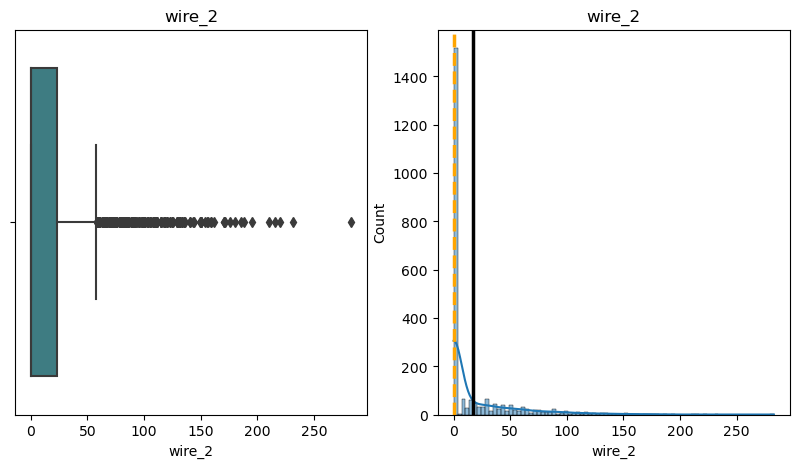

In [73]:
analysis(data_final, step=2)

Увсех признаков присутствуют выбросы.
Данные за исключением `bulk1-15` и `wire2-9` распределены нормально.

### Корреляция

In [74]:
numlist = data_final.columns

In [75]:

cf = data_final.phik_matrix(interval_cols=numlist) 
cf.style.background_gradient(cmap='Blues')



,A,duration_arc,full_power,count_arc,temp_begin,temp_final,temp_duration,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,wire_1,wire_2
A,1.000000,0.845579,0.335851,0.784961,0.287168,0.238358,0.719927,0.052604,0.068512,0.577925,0.368820,0.219049,0.399642,0.051070,0.100275
duration_arc,0.845579,1.000000,0.143353,0.809200,0.348086,0.275062,0.734567,0.070731,0.096035,0.585879,0.482664,0.264003,0.398222,0.078320,0.000000
full_power,0.335851,0.143353,1.000000,0.322249,0.115921,0.000000,0.000000,0.000000,0.000000,0.066115,0.075506,0.000000,0.154463,0.037049,0.054368
count_arc,0.784961,0.809200,0.322249,1.000000,0.308870,0.286749,0.734048,0.111218,0.000000,0.563077,0.506813,0.237054,0.507936,0.136051,0.116116
temp_begin,0.287168,0.348086,0.115921,0.308870,1.000000,0.406047,0.197713,0.121804,0.233025,0.216199,0.236086,0.206971,0.140539,0.230282,0.165111
temp_final,0.238358,0.275062,0.000000,0.286749,0.406047,1.000000,0.276698,0.000000,0.289108,0.351371,0.310577,0.314336,0.198683,0.357799,0.286494
temp_duration,0.719927,0.734567,0.000000,0.734048,0.197713,0.276698,1.000000,0.000000,0.000000,0.509676,0.255287,0.322673,0.493090,0.303293,0.316639
bulk_3,0.052604,0.070731,0.000000,0.111218,0.121804,0.000000,0.000000,1.000000,0.298459,0.000000,0.077360,0.000000,0.114434,0.217079,0.220429
bulk_4,0.068512,0.096035,0.000000,0.000000,0.233025,0.289108,0.000000,0.298459,1.000000,0.160309,0.084534,0.123870,0.109749,0.260687,0.286289
bulk_12,0.577925,0.585879,0.066115,0.563077,0.216199,0.351371,0.509676,0.000000,0.160309,1.000000,0.740759,0.774989,0.310453,0.214538,0.095703


Мультиколлинеарность  отсутствует.

In [76]:
#data_final = data_final.drop(['wire_4'],axis=1)

In [77]:
data_final

,A,duration_arc,full_power,count_arc,temp_begin,temp_final,temp_duration,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,wire_1,wire_2
key,,,,,,,,,,,,,,,
1,770.282114,1098.0,0.743747,5,1571.0,1613.0,1714.0,0.0,43.0,206.0,150.0,154.0,29.749986,60.059998,0.00000
2,481.760005,811.0,0.647087,4,1581.0,1602.0,1265.0,0.0,73.0,206.0,149.0,154.0,12.555561,96.052315,0.00000
3,722.837668,655.0,1.003845,5,1596.0,1599.0,1753.0,0.0,34.0,205.0,152.0,153.0,28.554793,91.160157,0.00000
4,683.455597,741.0,0.850010,4,1601.0,1625.0,1220.0,0.0,81.0,207.0,153.0,154.0,18.841219,89.063515,0.00000
5,512.169934,869.0,0.704245,4,1576.0,1602.0,1536.0,0.0,78.0,203.0,151.0,152.0,5.413692,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,694.177326,723.0,0.967180,4,1570.0,1591.0,1380.0,21.0,0.0,256.0,129.0,223.0,7.125735,89.150879,0.00000
2496,815.818538,940.0,0.845053,6,1554.0,1591.0,1705.0,0.0,63.0,256.0,129.0,226.0,9.412616,114.179527,0.00000
2497,823.020520,569.0,1.453639,3,1571.0,1589.0,962.0,0.0,85.0,230.0,124.0,226.0,6.271699,94.086723,9.04800


**Вывод**
Все данные были объединены за исключением данных о времени сыпучих и проволочных материалов.
- Удалены признаки в которых пропусков больше 80%.

При исследовании у всех признаков присутствуют выбросы. Большинство данных распределены нормально.
Мультиколлинеарность  отсутствует.


### Подготовка данных

In [78]:
# создадим тренировачную и обучающую выборки
X = data_final.drop(['temp_final'],axis=1)
y = data_final['temp_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
display('X_train:', X_train.shape)
display('y_train',y_train.shape)
display('X_test',X_test.shape)
'y_test',y_test.shape

'X_train:'

(1737, 14)

'y_train'

(1737,)

'X_test'

(580, 14)

('y_test', (580,))

In [79]:
selector = SelectKBest(f_classif, k=len(X_train.columns))
col_num = list(X_train.select_dtypes(exclude='object').columns)

In [80]:
# замена значений выбросов на значения "ближайшего уса"boxplota
for i in col_num:
    X_train = emissions(X_train,i)
X_train.shape

(1737, 14)

In [81]:
preprocessor = ColumnTransformer(
    [
    ('num', StandardScaler(), col_num)
    ], 
    remainder='passthrough') 

**Вывод**

Созданы Тренировочная и обучающая выборки. Создан пай план с масштабированием данных. Обработаны выбросы.



## Обучение моделей

#### LinearRegression

In [82]:
param_lr ={
     'selector__k': distributions.IntDistribution (1,len(X_train.columns))
}
lr_model = Pipeline(
    [('preprocessor', preprocessor),
    ('selector', selector),
    ('models', LinearRegression())])

In [83]:
model_lr = OSCV(lr_model,param_lr, 100)
model_lr.fit(X_train,y_train)



[I 2024-04-28 10:42:47,521] A new study created in memory with name: no-name-180f0dd8-4633-425b-98ef-5c5204a553b0
[I 2024-04-28 10:42:48,043] Trial 2 finished with value: -6.0940249861186855 and parameters: {'selector__k': 13}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:48,083] Trial 3 finished with value: -6.699057712499446 and parameters: {'selector__k': 5}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:48,086] Trial 4 finished with value: -6.1134877036652435 and parameters: {'selector__k': 11}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:48,093] Trial 1 finished with value: -6.39338648593891 and parameters: {'selector__k': 6}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:48,119] Trial 0 finished with value: -6.287837031023857 and parameters: {'selector__k': 7}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:48,124] Trial 5 finished with value: -6.296860128226161 an

[I 2024-04-28 10:42:52,038] Trial 50 finished with value: -6.130213511363005 and parameters: {'selector__k': 10}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:52,421] Trial 51 finished with value: -6.130213511363005 and parameters: {'selector__k': 10}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:52,457] Trial 55 finished with value: -6.130213511363005 and parameters: {'selector__k': 10}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:52,464] Trial 52 finished with value: -7.823965133022736 and parameters: {'selector__k': 1}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:52,471] Trial 54 finished with value: -7.64124801406304 and parameters: {'selector__k': 2}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:52,520] Trial 56 finished with value: -6.1134877036652435 and parameters: {'selector__k': 11}. Best is trial 2 with value: -6.0940249861186855.
[I 2024-04-28 10:42:52,5

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('num',
                                                                           StandardScaler(),
                                                                           ['A',
                                                                            'duration_arc',
                                                                            'full_power',
                                                                            'count_arc',
                                                                            'temp_begin',
                                                                            'temp_duration',
                                                                            'bulk_3',
                                                                            'bulk_4',
                                                                            'bulk_12',
                                                                            'bulk_14',
                                                                            'bulk_15',
                                                                            'gas',
                                                                            'wire_1',
                                                                            'wire_2'])])),
                                         ('selector', SelectKBest(k=14)),
                                         ('models', LinearRegression())]),
               n_jobs=-1, n_trials=100,
               param_distributions={'selector__k': IntDistribution(high=14, log=False, low=1, step=1)},
               random_state=220424, scoring='neg_mean_absolute_error')

In [84]:
"Значение метрики МАЕ линейной регресии", model_lr.best_score_ *-1

('Значение метрики МАЕ линейной регресии', 6.0940249861186855)

In [126]:

pipe_cat = Pipeline(
    [
     ('selector',selector),
     ('models',CatBoostRegressor(loss_function='MAE', verbose=False,
                               random_state=RANDOM_STATE))])
param_cat = {
      'models__colsample_bylevel': distributions.FloatDistribution(0.01,1,step = 0.01),
      'models__learning_rate'    : distributions.FloatDistribution(0.005, 0.3, step=0.01),
      'models__iterations'       : distributions.IntDistribution(500,2000, step=100),
      'models__depth'            : distributions.IntDistribution(5,16),
      'selector__k'              : distributions.IntDistribution(1,len(X_train.columns))
      }

In [127]:
%%time
cat = OSCV(pipe_cat,param_cat,10)
cat.fit(X_train,y_train)
cat.best_score_ *-1

[I 2024-04-28 11:14:05,972] A new study created in memory with name: no-name-96c0f2f1-41ab-4fae-b701-545d1fd249c5
[I 2024-04-28 11:14:08,588] Trial 2 finished with value: -6.621215738797308 and parameters: {'models__colsample_bylevel': 0.11, 'models__learning_rate': 0.125, 'models__iterations': 700, 'models__depth': 8, 'selector__k': 5}. Best is trial 2 with value: -6.621215738797308.
[I 2024-04-28 11:14:09,838] Trial 1 finished with value: -6.684651631109058 and parameters: {'models__colsample_bylevel': 0.01, 'models__learning_rate': 0.20500000000000002, 'models__iterations': 1000, 'models__depth': 8, 'selector__k': 13}. Best is trial 2 with value: -6.621215738797308.
[I 2024-04-28 11:14:10,124] Trial 5 finished with value: -7.46715688148071 and parameters: {'models__colsample_bylevel': 0.21000000000000002, 'models__learning_rate': 0.025, 'models__iterations': 1000, 'models__depth': 8, 'selector__k': 2}. Best is trial 2 with value: -6.621215738797308.
[I 2024-04-28 11:14:19,466] Trial

KeyboardInterrupt: 

In [114]:
display('CatBoost метрика MAE на тренировойчной выборке:',cat.best_score_ *-1)

'CatBoost метрика MAE на тренировойчной выборке:'

5.969961006234813

### LGBMRegressor


In [88]:

#pipe_lgbm = LGBMRegressor(seed=RANDOM_STATE)
param_grid = {
                   'models__max_depth'        : distributions.IntDistribution(1, 16),
                   'models__subsample'        : distributions.FloatDistribution(0.1, 1, step=0.1),
                   'models__feature_fraction' : distributions.FloatDistribution(0.1, 1,step= 0.1),
                   'models__reg_alpha'        : distributions.FloatDistribution(0, 1),
                   'models__reg_lambda'       : distributions.IntDistribution(0, 30),
                   'models__learning_rate'    : distributions.FloatDistribution(0.005, 0.5, step=0.01),
                   'models__n_estimators'     : distributions.IntDistribution(500, 2000,step=100),
                   'selector__k'              : distributions.IntDistribution(1,len(X_train.columns))
      }
pipe_lgbm = Pipeline(
    [
     ('selector',selector),
     ('models',LGBMRegressor(metric='mae' ,num_leaves=1000,random_state=RANDOM_STATE))])

In [89]:
%%time
lgbm = OSCV(pipe_lgbm,param_grid,100)
lgbm.fit(X_train,y_train)


[I 2024-04-28 10:45:15,380] A new study created in memory with name: no-name-e33b2375-73d9-471f-8aba-b6aa3f242d4b
[I 2024-04-28 10:45:21,031] Trial 5 finished with value: -8.326230669976677 and parameters: {'models__max_depth': 4, 'models__subsample': 1.0, 'models__feature_fraction': 0.5, 'models__reg_alpha': 0.32908571403624864, 'models__reg_lambda': 10, 'models__learning_rate': 0.41500000000000004, 'models__n_estimators': 500, 'selector__k': 1}. Best is trial 5 with value: -8.326230669976677.
[I 2024-04-28 10:45:37,352] Trial 6 finished with value: -6.4288483266049585 and parameters: {'models__max_depth': 7, 'models__subsample': 0.6, 'models__feature_fraction': 0.6, 'models__reg_alpha': 0.03937756254615099, 'models__reg_lambda': 1, 'models__learning_rate': 0.215, 'models__n_estimators': 900, 'selector__k': 13}. Best is trial 6 with value: -6.4288483266049585.
[I 2024-04-28 10:45:40,073] Trial 4 finished with value: -6.9026810277195 and parameters: {'models__max_depth': 12, 'models__s

[I 2024-04-28 10:46:40,000] Trial 23 finished with value: -6.555094725629074 and parameters: {'models__max_depth': 6, 'models__subsample': 0.7000000000000001, 'models__feature_fraction': 1.0, 'models__reg_alpha': 0.6268616977836485, 'models__reg_lambda': 23, 'models__learning_rate': 0.085, 'models__n_estimators': 2000, 'selector__k': 9}. Best is trial 19 with value: -6.008379278679591.
[I 2024-04-28 10:46:45,637] Trial 21 finished with value: -6.7466594228413515 and parameters: {'models__max_depth': 10, 'models__subsample': 0.8, 'models__feature_fraction': 0.30000000000000004, 'models__reg_alpha': 0.659395971144474, 'models__reg_lambda': 22, 'models__learning_rate': 0.085, 'models__n_estimators': 1600, 'selector__k': 9}. Best is trial 19 with value: -6.008379278679591.
[I 2024-04-28 10:46:50,746] Trial 24 finished with value: -6.6703646901066405 and parameters: {'models__max_depth': 6, 'models__subsample': 0.8, 'models__feature_fraction': 0.4, 'models__reg_alpha': 0.7136010510129411, '

[I 2024-04-28 10:48:01,327] Trial 43 finished with value: -6.30885095103798 and parameters: {'models__max_depth': 7, 'models__subsample': 0.5, 'models__feature_fraction': 0.6, 'models__reg_alpha': 0.5541864718008686, 'models__reg_lambda': 25, 'models__learning_rate': 0.17500000000000002, 'models__n_estimators': 1700, 'selector__k': 14}. Best is trial 40 with value: -6.006045640857356.
[I 2024-04-28 10:48:03,129] Trial 47 finished with value: -6.364133197657063 and parameters: {'models__max_depth': 5, 'models__subsample': 0.2, 'models__feature_fraction': 1.0, 'models__reg_alpha': 0.8802382493051147, 'models__reg_lambda': 25, 'models__learning_rate': 0.17500000000000002, 'models__n_estimators': 1800, 'selector__k': 14}. Best is trial 40 with value: -6.006045640857356.
[I 2024-04-28 10:48:04,369] Trial 48 finished with value: -6.133384506283915 and parameters: {'models__max_depth': 5, 'models__subsample': 0.2, 'models__feature_fraction': 1.0, 'models__reg_alpha': 0.7267858207090074, 'mode

[I 2024-04-28 10:48:31,359] Trial 65 finished with value: -6.259664165229769 and parameters: {'models__max_depth': 2, 'models__subsample': 0.5, 'models__feature_fraction': 0.8, 'models__reg_alpha': 0.32275168397490867, 'models__reg_lambda': 27, 'models__learning_rate': 0.015, 'models__n_estimators': 1200, 'selector__k': 7}. Best is trial 57 with value: -5.967984446689059.
[I 2024-04-28 10:48:31,512] Trial 69 finished with value: -6.8660586010245455 and parameters: {'models__max_depth': 2, 'models__subsample': 0.7000000000000001, 'models__feature_fraction': 0.4, 'models__reg_alpha': 0.2889082182140159, 'models__reg_lambda': 27, 'models__learning_rate': 0.015, 'models__n_estimators': 1200, 'selector__k': 3}. Best is trial 57 with value: -5.967984446689059.
[I 2024-04-28 10:48:31,522] Trial 68 finished with value: -6.929252787219868 and parameters: {'models__max_depth': 2, 'models__subsample': 0.5, 'models__feature_fraction': 0.5, 'models__reg_alpha': 0.28421117981983085, 'models__reg_lam

[I 2024-04-28 10:49:11,035] Trial 92 finished with value: -5.969313481590689 and parameters: {'models__max_depth': 3, 'models__subsample': 1.0, 'models__feature_fraction': 0.6, 'models__reg_alpha': 0.082084654866207, 'models__reg_lambda': 21, 'models__learning_rate': 0.025, 'models__n_estimators': 1000, 'selector__k': 11}. Best is trial 89 with value: -5.963604132979233.
[I 2024-04-28 10:49:11,045] Trial 91 finished with value: -6.057142673472332 and parameters: {'models__max_depth': 3, 'models__subsample': 1.0, 'models__feature_fraction': 0.6, 'models__reg_alpha': 0.034498263548778635, 'models__reg_lambda': 23, 'models__learning_rate': 0.025, 'models__n_estimators': 1000, 'selector__k': 10}. Best is trial 89 with value: -5.963604132979233.
[I 2024-04-28 10:49:11,870] Trial 83 finished with value: -6.057150835458793 and parameters: {'models__max_depth': 6, 'models__subsample': 0.9, 'models__feature_fraction': 0.8, 'models__reg_alpha': 0.13485295627546895, 'models__reg_lambda': 29, 'mod

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 1737, number of used features: 12
[LightGBM] [Info] Start training from score 1593.345999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('selector', SelectKBest(k=14)),
                                         ('models',
                                          LGBMRegressor(metric='mae',
                                                        num_leaves=1000,
                                                        random_state=220424))]),
               n_jobs=-1, n_trials=100,
               param_distributions={'models__feature_fraction': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1),
                                    'models__learning_rate': FloatDistribution(high=0.495, log=False, low=0.0...
                                    'models__n_estimators': IntDistribution(high=2000, log=False, low=500, step=100),
                                    'models__reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'models__reg_lambda': IntDistribution(high=30, log=False, low=0, step=1),
                                    'models__subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1),
                                    'selector__k': IntDistribution(high=14, log=False, low=1, step=1)},
               random_state=220424, scoring='neg_mean_absolute_error')

In [90]:
display('LGBM метрика MAE на тренировойчной выборке:',lgbm.best_score_ *-1)
lgbm.best_params_

'LGBM метрика MAE на тренировойчной выборке:'

5.963604132979233

{'models__max_depth': 3,
 'models__subsample': 1.0,
 'models__feature_fraction': 0.8,
 'models__reg_alpha': 0.06561496936665098,
 'models__reg_lambda': 22,
 'models__learning_rate': 0.025,
 'models__n_estimators': 1000,
 'selector__k': 12}

In [149]:
param_grid_dtc ={
        'models__max_depth': distributions.IntDistribution(2,16),
        'models__min_samples_leaf': distributions.IntDistribution(2,7),
        'models__max_features': distributions.IntDistribution(3,7),
        #'models__min_samples_split': distributions.IntDistribution(3,7),
        'selector__k': distributions.IntDistribution(1,17)
        
}
pipe_dtc = Pipeline(
    [('preprocessor', preprocessor),
     ('selector', selector),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

In [150]:
%%time
dtr = OSCV(pipe_dtc,param_grid_dtc,50)
dtr.fit(X_train,y_train)
dtr.best_score_ *-1

[I 2024-04-28 12:50:51,582] A new study created in memory with name: no-name-a5e6839e-63c4-437e-a1f2-6b714a2a169d
[W 2024-04-28 12:50:51,744] Trial 2 failed with parameters: {'models__max_depth': 10, 'models__min_samples_leaf': 3, 'models__max_features': 3, 'selector__k': 16} because of the following error: The value nan is not acceptable.
[W 2024-04-28 12:50:51,747] Trial 2 failed with value nan.
[I 2024-04-28 12:50:52,006] Trial 5 finished with value: -7.526039449815727 and parameters: {'models__max_depth': 5, 'models__min_samples_leaf': 3, 'models__max_features': 4, 'selector__k': 12}. Best is trial 5 with value: -7.526039449815727.
[I 2024-04-28 12:50:52,046] Trial 0 finished with value: -7.832839844584347 and parameters: {'models__max_depth': 3, 'models__min_samples_leaf': 2, 'models__max_features': 3, 'selector__k': 1}. Best is trial 5 with value: -7.526039449815727.
[I 2024-04-28 12:50:52,074] Trial 1 finished with value: -7.318672925379596 and parameters: {'models__max_depth': 

[W 2024-04-28 12:50:54,079] Trial 32 failed with value nan.
[W 2024-04-28 12:50:54,186] Trial 34 failed with parameters: {'models__max_depth': 6, 'models__min_samples_leaf': 7, 'models__max_features': 3, 'selector__k': 17} because of the following error: The value nan is not acceptable.
[W 2024-04-28 12:50:54,188] Trial 34 failed with value nan.
[W 2024-04-28 12:50:54,232] Trial 35 failed with parameters: {'models__max_depth': 7, 'models__min_samples_leaf': 7, 'models__max_features': 5, 'selector__k': 16} because of the following error: The value nan is not acceptable.
[W 2024-04-28 12:50:54,235] Trial 35 failed with value nan.
[W 2024-04-28 12:50:54,259] Trial 36 failed with parameters: {'models__max_depth': 7, 'models__min_samples_leaf': 7, 'models__max_features': 5, 'selector__k': 16} because of the following error: The value nan is not acceptable.
[W 2024-04-28 12:50:54,272] Trial 36 failed with value nan.
[I 2024-04-28 12:50:54,340] Trial 26 finished with value: -7.383470087049967

CPU times: total: 4.45 s
Wall time: 3.74 s


7.15238013639715

In [151]:
' DecisionTree, метрика MAE  на тренировойчной выборке:',dtr.best_score_ *-1

(' DecisionTree, метрика MAE  на тренировойчной выборке:', 7.15238013639715)

In [115]:
#Определим лучшую модель
best_mae = pd.DataFrame( index=['Linear regresion', 'Catboost', 'LGBMR', 'DecisionTree'],
                       data = {'best_mae':[model_lr.best_score_, 
                                          cat.best_score_, lgbm.best_score_, dtr.best_score_]})
best_mae['best_mae'] = best_mae['best_mae'] *-1
best_mae

,best_mae
Linear regresion,6.094025
Catboost,5.969961
LGBMR,5.963604
DecisionTree,7.253598


Лучшая модель LGBM имеет MAE равной 5.95 при 13 признаках.

In [95]:
lgbm.best_params_

{'models__max_depth': 3,
 'models__subsample': 1.0,
 'models__feature_fraction': 0.8,
 'models__reg_alpha': 0.06561496936665098,
 'models__reg_lambda': 22,
 'models__learning_rate': 0.025,
 'models__n_estimators': 1000,
 'selector__k': 12}

In [122]:
model = lgbm.best_estimator_


Для машинного обучения использовались 4 модели:
 - LinearRegression, метрика mae -6.09.
 - CatBoostRegression, метрика mae -6.14.
 - LGBMRegressor, метрика mae -5.95.
 - DecisionTreeRegressor, метрика mae -7.1.
 
Из них определили лучшую модель - LGBMRegressor. Ее и протестируем на тестовых данных и сравним с dummy моделью.

### Проверка на тестовой модели

In [110]:
# dummy модель для проверки на адекватность
dumm =DummyRegressor()
dumm.fit(X_train, y_train)
mean_absolute_error(y_test, dumm.predict(X_test))

8.15064121652472

In [123]:
mean_absolute_error(y_test, model.predict(X_test))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


6.041978994034476

In [124]:
r2_score(y_test,model.predict(X_test))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


0.44805574300449913

Коэффициент детерминации показывает, что модель предсказывает верно в 44 процентах случаев предсказание модели ближе к истине, чем среднее значение целевого признака.

In [100]:
selector = SelectKBest(f_classif, k=lgbm.best_params_['selector__k'])
selector.fit_transform(X_train,y_train)

features_test = pd.DataFrame(
    selector.transform(X_test,y_test),
    columns=selector.get_feature_names_out()  
)

len(features_test.columns)

12

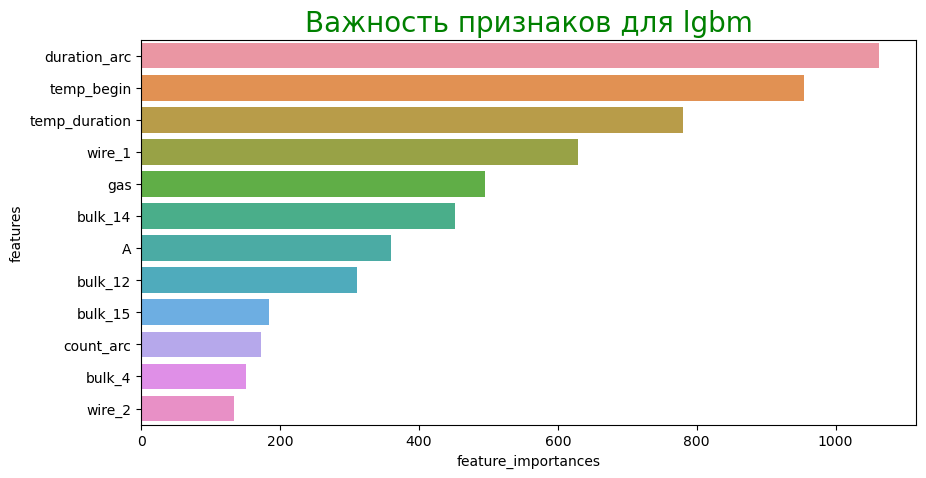

In [101]:
plot_data = {
    'features': features_test.columns,
    'feature_importances': model._final_estimator.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(10, 5))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для lgbm',fontsize=20, color='green')
plt.show()

Из всех признаков отобрали 12 при которых модель обучается лучше всего. Больше всего на предсказание влияют: 
- длительность работы электродов(duration_arc), 
- начальная температура(temp_begin), 
- использование материала проволоки №1(wire1)  
- длительность достижения нужной температуры(temp_duration).


## Вывод

Были загружены и исследованы данные по промышленности. Данные о времени и дате были приведены к типу дата. Названия столбцов приведены к стандарту. Проверены на пропуски и дубликаты.
Проведены исследования и преобразования таблиц:

Добавлены новые признаки:
   - Полной мощности.
   - Работы.
   - Количества итераций.
   - Время работы электродов в секундах.   
   - созданы признаки Начальной и последней температуры. 
   - время между последним замером температуры и первым.
     Удалены столбцы:
   - Дата\времени
   - активной мощности
   - реактивной мощности.
   - удалены признаки с датой/временем.
- Удалены ключи где замер температуры производился только один раз.
- все пропуски заменены на 0.


Все данные были объединены в один дат фрейм по ключу.
- Пропусков и дубликатов нет.
- Был провиден исследовательский анализ данных
- был провиден корреляционный анализ.

Проведена подготовка данных к обучению:
- данные разбиты на тренировочную и обучающую выборки.
- созданы пай планы моделей.

Были обучены четыре модели:
 - LinearRegression, метрика mae -5.92.
 - CatBoostRegression, метрика mae -5.92.
 - LGBMRegressor, метрика mae -5.92.
 - DecisionTreeRegressor, метрика mae -5.92.
 
Из них определили лучшую модель - LGBMRegressor. Параметры лучшей модели при 9 признаках:
- 'max_depth': 1,
- 'subsample': 0.2,
- 'feature_fraction': 0.6,
- 'reg_alpha': 0.11295740006862251,
- 'reg_lambda': 30,
- 'learning_rate': 0.255,
- 'n_estimators': 900
 
Проверка на адекватность пройдена. dumm
Метрика MAE на тестовых данных - 6,1.
